In [1]:
from PIL import Image, ImageOps
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
#Transformada de Fourier
from scipy.fft import fft, fftfreq, ifft
#Funçoes Auxiliares
from PIL_Functions import img_to_matrix, soma_linhas
#Ouvir a Cena
from scipy.interpolate import interp1d

In [2]:
plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 1.5

# Funções Auxliares

In [3]:
def imita(matrix):
    new_matrix = list()
    linha      = list()
    for i in matrix:
        for j in i:
            linha.append(j)
        new_matrix.append(linha)
        linha=list()
    return new_matrix
    
    

def threshold(matrix, t, color, save_bkg=False):
    new_matrix = imita(matrix)
    
    if(save_bkg):
        bkg    = imita(matrix)
    
    width = len(matrix[0])
    height= len(matrix)
    
    for linha in range(height):
        for coluna in range(width):
            if new_matrix[linha][coluna] <= t:
                new_matrix[linha][coluna] = color
            else:
                if save_bkg:
                    bkg[linha][coluna] = color
    if save_bkg:
        return new_matrix, bkg
    return new_matrix



def integrate(linha):
    integral = 0
    for i in linha:
        integral += i
    return integral



def normalize(linha):
    maximo = max(linha)
    return [i/maximo for i in linha]



def get_region(x, y, borders):
    x_reg = list()
    y_reg = list()
    assert(len(x) == len(y))
    for i in range(len(y)):
        if x[i] >= borders[0] and x[i] <= borders[1]:
            x_reg.append(x[i])
            y_reg.append(y[i])
    return x_reg, y_reg
   
    
    
def crop(matrix, x_reg, y_reg):
    new_matrix = matrix[y_reg[0]:y_reg[1]][x_reg[0]:x_reg[1]].copy()
    return new_matrix

In [4]:
path = '/Users/thomasgaehtgens/Desktop/LFEA/High Harmonic Generation/Notebooks/Espectro.tiff' #MUDAR ESTE PATH CASO NÃO SEJAS O THOMAS

In [5]:
img = Image.open(path)

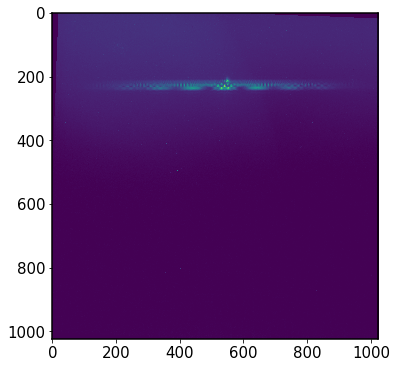

In [6]:
fig   = plt.figure(figsize=(6, 6))
plt.imshow(img)

In [7]:
matrix = img_to_matrix(img)
hist   = soma_linhas(img_to_matrix(img))

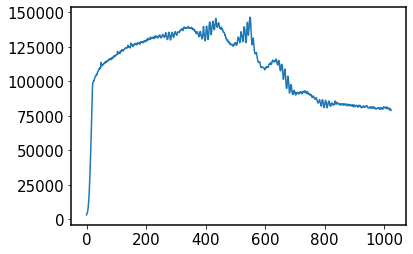

In [8]:
fig= plt.figure()
ax = fig.add_subplot()

ax.plot(hist)

O background não é linar ao longo da CCD. Aplica-se um threshold

In [9]:
matrix = img_to_matrix(img)
matrix_threshold = threshold(matrix, 460, 0)
hist_threshold   = soma_linhas(matrix_threshold)

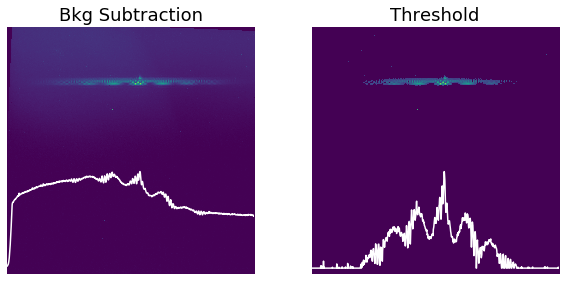

In [10]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

#ax3 = fig.add_subplot(2, 2, 3)
#ax4 = fig.add_subplot(2, 2, 4)

ax1.imshow(matrix)
ax1.set_title('Bkg Subtraction')
ax2.set_title('Threshold')
ax2.imshow(matrix_threshold)

ax1.plot(-400*np.array(normalize(hist))+1000, color='white')
ax2.plot(-400*np.array(normalize(hist_threshold))+1000, color='white')

for ax in [ax1, ax2]:
    ax.axis(False) 
#GUARDA IMAGEM
#imageio.imwrite('img_threshold.png', np.array(matrix_threshold).astype(np.uint16))

## Transformada de Fourier

In [11]:
N           = len(hist)
SAMPLE_RATE = 100 #Herz - frequência dos pulsos(???? NÃO SEI O QUE POR AQUI!)

yf_t = fft(hist_threshold)
yf   = fft(hist)
xf = fftfreq(N, 1/SAMPLE_RATE)

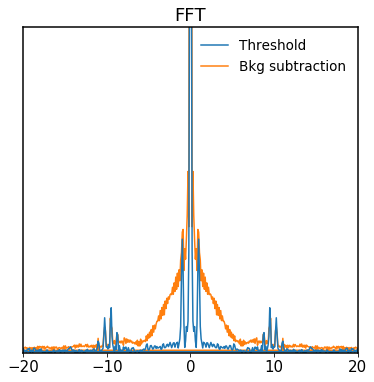

In [12]:
fig = plt.figure(figsize=(6, 6))
ax  = fig.add_subplot()

ax.plot(xf, np.abs(yf_t), label='Threshold', zorder=2)
ax.plot(xf, np.abs(yf),   label='Bkg subtraction', zorder=1)

ax.set_xlim(-20, 20)
ax.set_ylim(0, 5000000)

ax.set_yticks([])
ax.set_title('FFT')

plt.legend(fontsize=13.5, frameon=False)

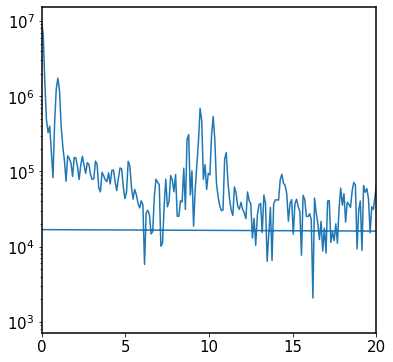

In [13]:
fig = plt.figure(figsize=(6, 6))
ax  = fig.add_subplot()

ax.plot(xf, np.abs(yf_t), label='Threshold')

ax.set_xlim(0, 20)
#ax.set_ylim(0, 5000000)
plt.yscale('log')



Para retirar a linha em baixo, ler [isto](https://www.kite.com/python/answers/how-to-sort-a-list-based-on-another-list-in-python)

In [14]:
x_t = [x for x, _ in sorted(zip(xf, yf_t))]
y_t = [y for _, y in sorted(zip(xf, yf_t))]

x_ = [x for x, _ in sorted(zip(xf, yf))]
y_ = [y for _, y in sorted(zip(xf, yf))]

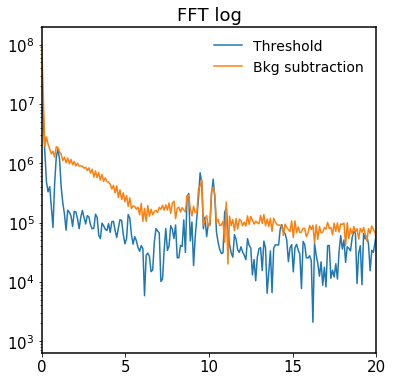

In [15]:
fig = plt.figure(figsize=(6, 6))
ax  = fig.add_subplot()

ax.plot(x_t, np.abs(y_t), label='Threshold')
ax.plot(x_, np.abs(y_),   label='Bkg subtraction')

ax.set_xlim(0, 20)
plt.yscale('log')

ax.set_title('FFT log')

plt.legend(fontsize=14, frameon=False)

## Determinação do tempo de aquisição ótimo

Obtivemos vários espectros de difração, para tempos diferentes. O meu objetivo agora é perceber qual o melhor tempo a usar na nossa análise.

Para isso, vou assumir que o melhor método para remover ruído é o *Threshold* e vou fazer plot do rácio dos integrais das intensidades $\frac{Sinal}{Ruído}$, para cada tempo de aquisição.

In [16]:
matrix_threshold, bkg = threshold(matrix, 460, 0, save_bkg=True)

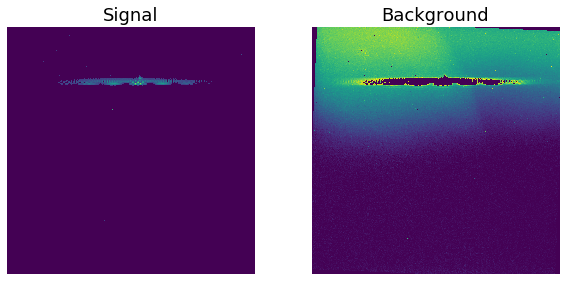

In [17]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

ax1.imshow(matrix_threshold)
ax1.set_title('Signal')
ax2.set_title('Background')
ax2.imshow(bkg)

for ax in [ax1, ax2]:
    ax.axis(False) 

In [18]:
print('Rácio = ' + str(integrate(soma_linhas(matrix_threshold))/integrate(soma_linhas(bkg))))

Rácio = 0.09575462153366907


Aplica-se agora aos resultados obtidos

In [19]:
path_imagens = '/Users/thomasgaehtgens/Desktop/LFEA/High Harmonic Generation/Dados/2a sessao/fendas/bkg_removed_images/'
paths        = [path_imagens + str(i + 1) + 's.tif' for i in range(7)]

In [20]:
images = [Image.open(i) for i in paths]
matrxs = [img_to_matrix(i) for i in images]

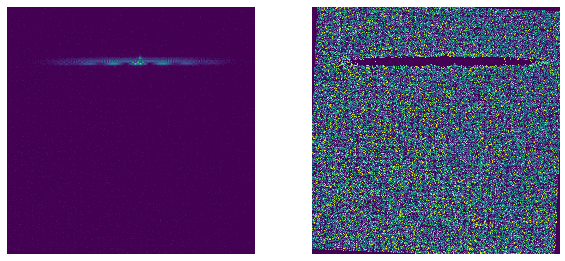

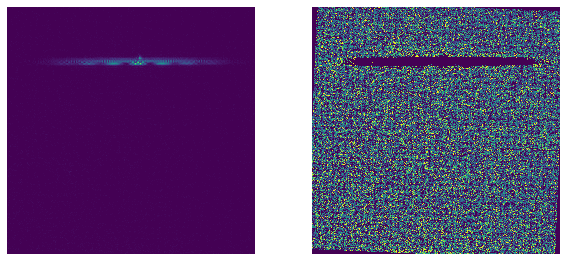

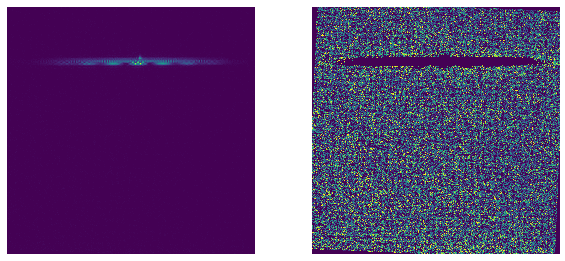

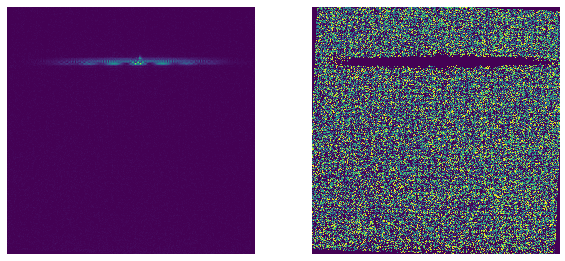

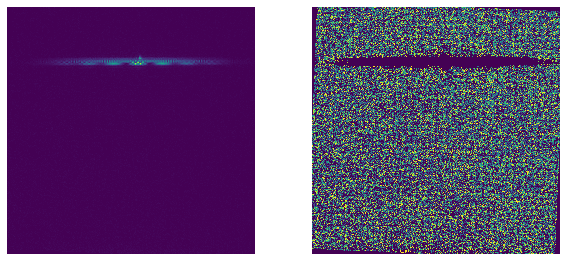

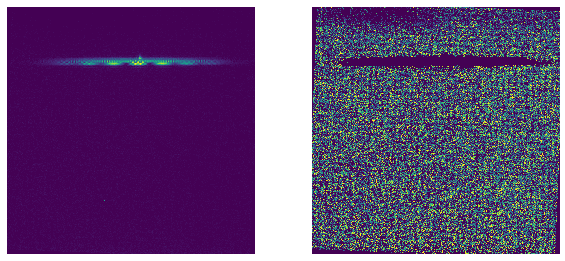

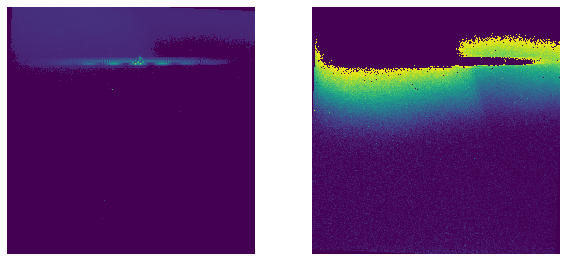

In [21]:
linhas = list()
racios = list()
t_val  = [10, 10, 10, 20, 20, 24, 350]
t_val  = [10, 10, 10, 10, 10, 10, 250]

for i in range(len(matrxs)):
    fig = plt.figure(figsize=(10, 10))
    
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    
    new_matrix, bkg = threshold(matrxs[i], t = t_val[i], color = 0, save_bkg=True) #105 uma delas fica cute
    
    
    ax1.imshow(new_matrix)
    ax2.imshow(bkg)
    
    for ax in [ax1, ax2]:
        ax.axis(False)
        
    racios.append(integrate(soma_linhas(new_matrix))/integrate(soma_linhas(bkg)))
    linhas.append(soma_linhas(new_matrix))

(-0.2, 3.2881994847303857)

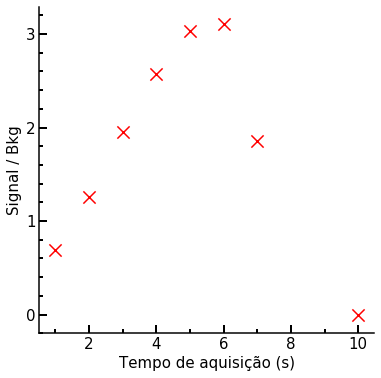

In [22]:
fig = plt.figure(figsize=(6, 6))
ax  = fig.add_subplot()

r = racios + [0]
ax.scatter([1, 2, 3, 4, 5, 6, 7, 10], r, color='red', s=150, marker='x')
ax.plot()

ax.set_xlabel(r'Tempo de aquisição (s)')
ax.set_ylabel(r'Signal / Bkg')

###### ESTÉTICAS ######

ax.xaxis.set_tick_params(which='major', size=8, width=2,  direction='in')
ax.xaxis.set_tick_params(which='minor', size=4, width=2,  direction='in')
ax.yaxis.set_tick_params(which='major', size=8, width=2, direction='in')
ax.yaxis.set_tick_params(which='minor', size=4, width=2, direction='in')

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.ylim(-0.2)

Observa-se um maior rácio para um tempo de aquisição de 6s, pelo que se escolhe o espectro correspondente para análise  

In [23]:
matrix = threshold(matrxs[-2], t = t_val[-2], color = 0, save_bkg=False) #105 uma delas fica cute

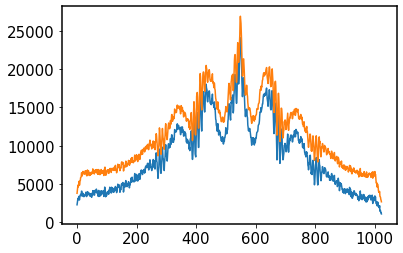

In [24]:
hist_threshold = linhas[-2]
hist           = soma_linhas(matrxs[-2])

plt.plot(hist_threshold)
plt.plot(hist)

In [25]:
N           = len(hist_threshold)
SAMPLE_RATE = 100 #Herz - frequência dos pulsos(???? NÃO SEI O QUE POR AQUI!)

yf_t = fft(hist_threshold)
yf   = fft(hist)
xf = fftfreq(N, 1/SAMPLE_RATE)

In [26]:
x_t = [x for x, _ in sorted(zip(xf, yf_t))]
y_t = [y for _, y in sorted(zip(xf, yf_t))]

x_ = [x for x, _ in sorted(zip(xf, yf))]
y_ = [y for _, y in sorted(zip(xf, yf))]

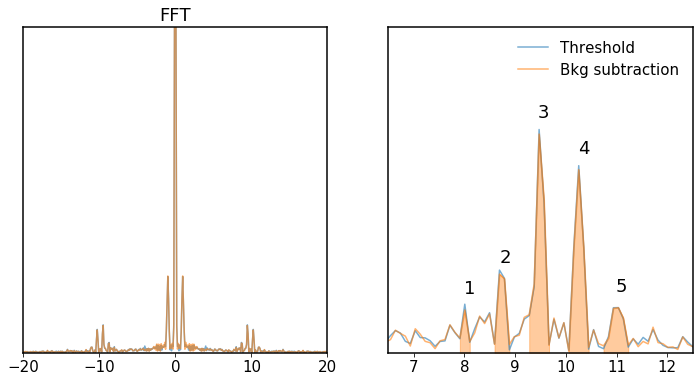

In [27]:
fig = plt.figure(figsize=(12, 6))
ax  = fig.add_subplot(1, 2, 1)

ax_section = fig.add_subplot(1, 2, 2)

ax.plot(x_t, np.abs(y_t), label='Threshold', alpha = 0.6)
ax.plot(x_, np.abs(y_),   label='Bkg subtraction', alpha = 0.6)

ax.set_xlim(-20, 20)
ax.set_ylim(0, 3200000)

ax.set_yticks([])
ax.set_title('FFT')

ax_section.plot(x_t, np.abs(y_t), label='Threshold', alpha = 0.6)
ax_section.plot(x_, np.abs(y_),   label='Bkg subtraction', alpha = 0.6)

####### ENCONTRAR OS HARMÓNICOS #######
x_h1, y_h1 = get_region(x_, y_, [7.9, 8.15])
x_h2, y_h2 = get_region(x_, y_, [8.5, 8.9])
x_h3, y_h3 = get_region(x_, y_, [9.2, 9.67])
x_h4, y_h4 = get_region(x_, y_, [10.05, 10.45])
x_h5, y_h5 = get_region(x_, y_, [10.65, 11.3])

plt.fill_between(x_h1,np.abs(y_h1), alpha = 0.4, color='C1')
plt.fill_between(x_h2,np.abs(y_h2), alpha = 0.4, color='C1')
plt.fill_between(x_h3,np.abs(y_h3), alpha = 0.4, color='C1')
plt.fill_between(x_h4,np.abs(y_h4), alpha = 0.4, color='C1')
plt.fill_between(x_h5,np.abs(y_h5), alpha = 0.4, color='C1')

#Enumeração
ax_section.text(8     , np.abs(y_h1[int(len(y_h1)/2)]) + 20000, '1', fontsize=18)
ax_section.text(8.7   , np.abs(y_h2[int(len(y_h2)/2)]) + 20000, '2', fontsize=18)
ax_section.text(9.435 , np.abs(y_h3[int(len(y_h3)/2)]) + 20000, '3', fontsize=18)
ax_section.text(10.25 , np.abs(y_h4[int(len(y_h4)/2)]) + 20000, '4', fontsize=18)
ax_section.text(10.975, np.abs(y_h5[int(len(y_h5)/2)]) + 20000, '5', fontsize=18)

#######################################

ax_section.set_yticks([])

ax_section.set_xlim(6.5, 12.5)
ax_section.set_ylim(0, 400000)

plt.legend(fontsize=15, frameon=False)

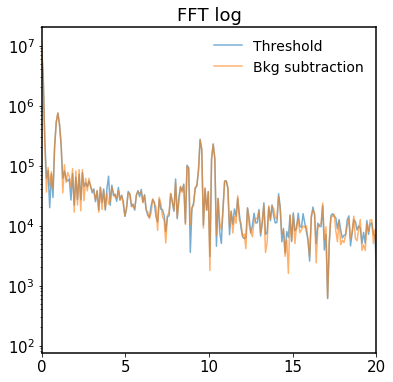

In [28]:
fig = plt.figure(figsize=(6, 6))
ax  = fig.add_subplot()

ax.plot(x_t, np.abs(y_t), label='Threshold', alpha = 0.6)
ax.plot(x_, np.abs(y_),   label='Bkg subtraction', alpha = 0.6)

ax.set_xlim(0, 20)
plt.yscale('log')

ax.set_title('FFT log')

plt.legend(fontsize=14, frameon=False)

O espectro obtido é composto por 3 espectro diferentes, cada um numa dada região de de y

# Separação do Espectro obtido nas suas 3 componentes

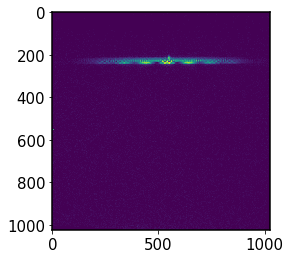

In [29]:
plt.imshow(matrix)

In [30]:
cropped = crop(matrix, [0, len(matrix)], [200, 245])

In [31]:
plt.axis(False)
plt.imshow(cropped)
plt.show()

In [32]:
linha1 = crop(cropped, [0, len(matrix)], [36, len(cropped)])

In [33]:
fig = plt.figure(figsize=(20, 1))
plt.axis(False)

plt.imshow(linha1)
plt.show()

In [34]:
linha2 = crop(cropped, [0, len(matrix)], [22, 36])

In [35]:
fig = plt.figure(figsize=(20, 1))
plt.axis(False)

plt.imshow(linha2)
plt.show()

In [36]:
linha3 = crop(cropped, [0, len(matrix)], [0, 22])

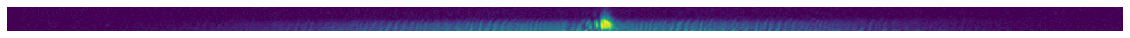

In [37]:
fig = plt.figure(figsize=(20, 1))
plt.axis(False)

plt.imshow(linha3)
plt.show()

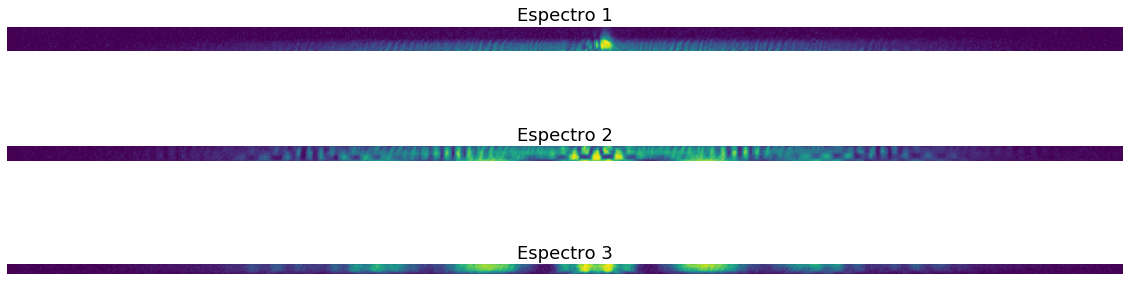

In [38]:
fig = plt.figure(figsize=(20, 6))

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

ax1.set_title('Espectro 1')
ax1.imshow(linha3)

ax2.set_title('Espectro 2')
ax2.imshow(linha2)

ax3.set_title('Espectro 3')
ax3.imshow(linha1)

axis = [ax1, ax2, ax3]
for ax in axis:
    ax.axis(False)

# Análise dos Espectros Individuais

In [39]:
hist1 = soma_linhas(linha1)
hist2 = soma_linhas(linha2)
hist3 = soma_linhas(linha3)

hist1f = np.abs(fft(hist1))
hist2f = np.abs(fft(hist2))
hist3f = np.abs(fft(hist3))

xf = fftfreq(N, 1/SAMPLE_RATE)

In [40]:
x_t    = [x for x, _ in sorted(zip(xf, hist1f))]
hist1f = [y for _, y in sorted(zip(xf, hist1f))]

x_t    = [x for x, _ in sorted(zip(xf, hist2f))]
hist2f = [y for _, y in sorted(zip(xf, hist2f))]

x_t    = [x for x, _ in sorted(zip(xf, hist3f))]
hist3f = [y for _, y in sorted(zip(xf, hist3f))]

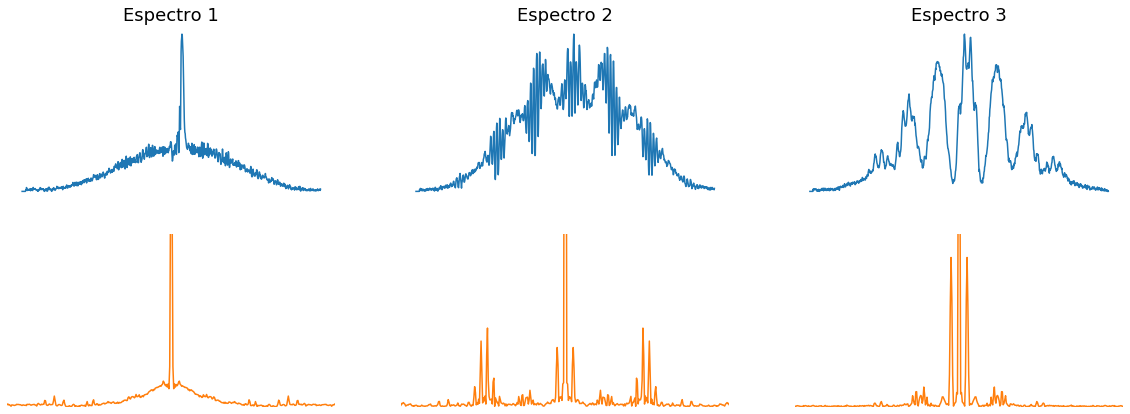

In [41]:
fig = plt.figure(figsize=(20, 7))
#Sinal
ax1  = fig.add_subplot(2, 3, 1)
ax2  = fig.add_subplot(2, 3, 2)
ax3  = fig.add_subplot(2, 3, 3)
#Transfomada
ax1f = fig.add_subplot(2, 3, 4)
ax2f = fig.add_subplot(2, 3, 5)
ax3f = fig.add_subplot(2, 3, 6)

ax1.set_title('Espectro 1')
ax1.plot(hist3, color='C0')

ax2.set_title('Espectro 2')
ax2.plot(hist2, color='C0')

ax3.set_title('Espectro 3')
ax3.plot(hist1, color='C0')

ax1f.plot(x_t, hist3f, color='C1')
ax2f.plot(x_t, hist2f, color='C1')
ax3f.plot(x_t, hist1f, color='C1')

axis = [ax1, ax2, ax3, ax1f, ax2f, ax3f]
for ax in axis:
    ax.axis(False)
for ax in axis[3:]:
    ax.set_ylim(0, 500000)
    ax.set_xlim(-20, 20)